In [ ]:
!jupyter nbconvert --execute --to html "/content/Proyecto_Final_PLN.ipynb"

[NbConvertApp] Converting notebook /content/Proyecto_Final_PLN.ipynb to html
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2025-07-22 11:34:12.362923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753184052.389595   31477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting 

# Proyecto Final PLN:

## 1. Carga y preprocesamiento de datos

In [ ]:
# Importamos las librerias necesarias

import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import random
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Descargamos recursos

nltk.download("movie_reviews")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

# Inicializamos el lematizador y el conjunto de stopwords en inglés

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Función de preprocesamiento: limpia y transforma el texto

def preprocess(text):
    tokens = word_tokenize(text.lower()) # Convertimos a minúsculas y tokenizamos
    tokens = [t for t in tokens if t.isalpha()]  # Elimina puntuación y números
    tokens = [t for t in tokens if t not in stop_words] # Eliminamos stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens] # Aplicamos lematización
    return ' '.join(tokens) # Devolvemos el texto limpio como string

# Cargamos las reseñas de NLTK y las mezclamos aleatoriamente

documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

# Aplicamos el preprocesamiento y separamos textos y etiquetas

texts = [preprocess(doc) for doc, _ in documents]
labels = [1 if label == "pos" else 0 for _, label in documents] # Positivas = 1, negativas = 0


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Entrenamiento del modelos de clasificación

### Naive Bayes

In [ ]:
# Importamos herramientas de Scikit-learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Vectorizamos los textos con TF-IDF para convertirlos a una matriz numérica

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts) # Creamos matriz de características
y = labels # Etiquetas ya codificadas anteriormente

# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Naive Bayes

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba

y_pred_nb = nb_model.predict(X_test)


### Keras

In [ ]:
# Importamos herramientas de Keras para procesamiento de texto y construcción del modelo

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import numpy as np

# Tokenización

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Rellenamos las secuencias para que todas tengan la misma longitud

padded = pad_sequences(sequences, maxlen=300)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(padded, y, test_size=0.2, random_state=42)

# Modelo Keras

model = Sequential([
    Embedding(input_dim=5000, output_dim=32), # Capa de embedding
    GlobalAveragePooling1D(), # Pooling para reducir dimensionalidad
    Dense(16, activation="relu"), # Capa densa oculta
    Dense(1, activation="sigmoid") # Capa de salida para clasificación binaria
])

# Compilamos el modelo con función de pérdida y métrica

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entrenamos el modelo
model.fit(X_train_nn, np.array(y_train_nn), epochs=5, validation_split=0.2, batch_size=32)

# Predecimos
y_pred_nn = (model.predict(X_test_nn) > 0.5).astype("int32")

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5205 - loss: 0.6925 - val_accuracy: 0.6219 - val_loss: 0.6868
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6873 - loss: 0.6850 - val_accuracy: 0.6469 - val_loss: 0.6758
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7286 - loss: 0.6670 - val_accuracy: 0.7094 - val_loss: 0.6487
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7830 - loss: 0.6191 - val_accuracy: 0.7312 - val_loss: 0.6166
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8852 - loss: 0.5421 - val_accuracy: 0.7719 - val_loss: 0.5473
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## 3.Evaluación del modelo

Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       190
           1       0.87      0.78      0.82       210

    accuracy                           0.82       400
   macro avg       0.83      0.83      0.82       400
weighted avg       0.83      0.82      0.82       400

Red Neuronal:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       190
           1       0.92      0.64      0.75       210

    accuracy                           0.78       400
   macro avg       0.81      0.79      0.78       400
weighted avg       0.81      0.78      0.78       400



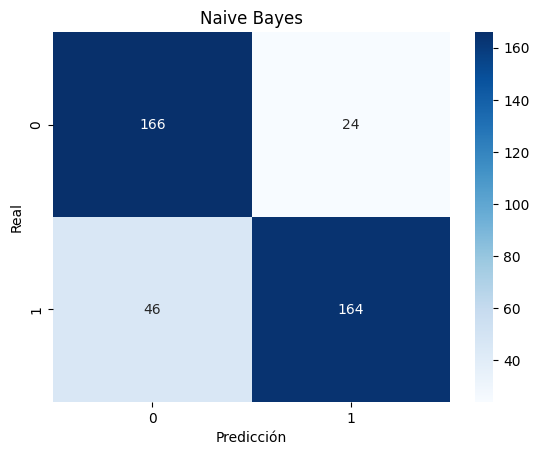

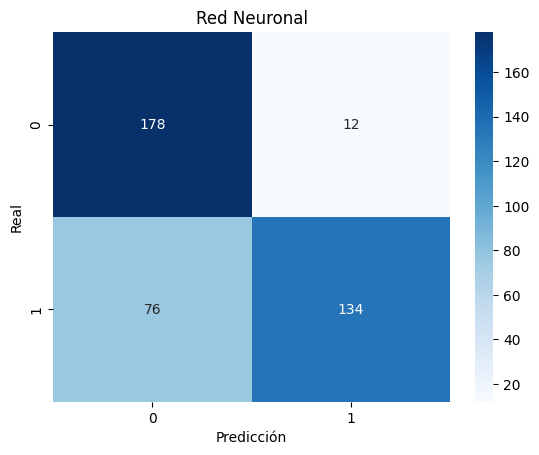

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


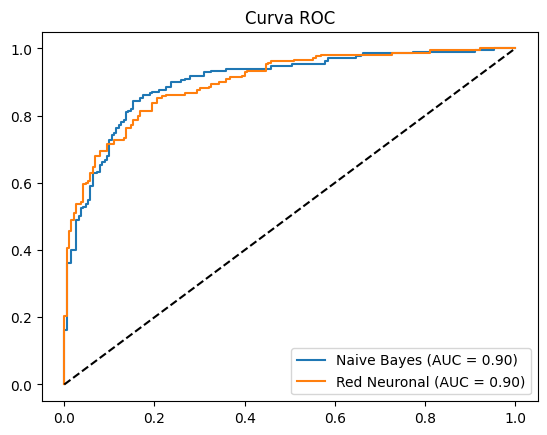

In [ ]:
# Importamos funciones para evaluación de modelos
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Mostramos informe de métricas para Naive Bayes
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

# Mostramos informe de métricas para Red Neuronal
print("Red Neuronal:")
print(classification_report(y_test_nn, y_pred_nn))

# Matriz de confusión
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_conf_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_conf_matrix(y_test_nn, y_pred_nn, "Red Neuronal")

# Curvas ROC
def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

# Calculamos probabilidades para la curva ROC
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]
y_prob_nn = model.predict(X_test_nn).ravel()

# Mostramos curvas ROC de ambos modelos
plt.figure()
plot_roc(y_test, y_prob_nb, "Naive Bayes")
plot_roc(y_test_nn, y_prob_nn, "Red Neuronal")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.legend()
plt.show()

## 4.Visualización de resultados

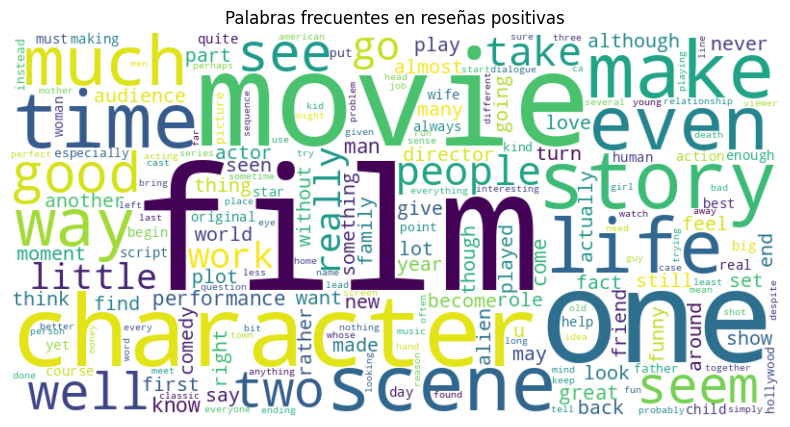

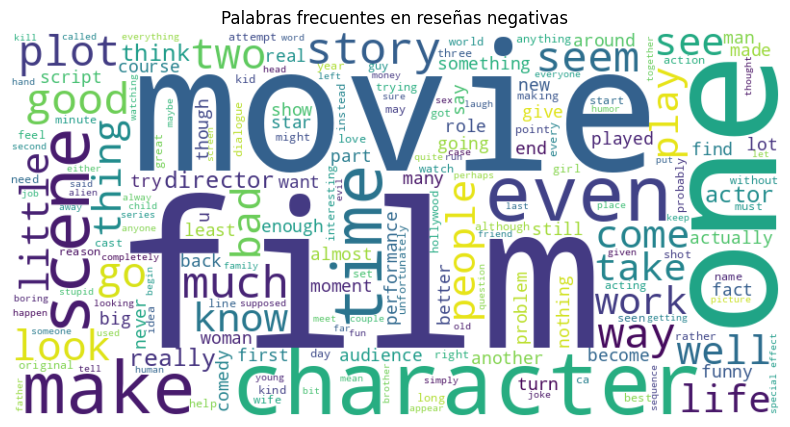

In [ ]:
# Importamos librería para generar nubes de palabras
from wordcloud import WordCloud

# Separamos los textos según su clase
pos_text = ' '.join([texts[i] for i in range(len(texts)) if labels[i] == 1])
neg_text = ' '.join([texts[i] for i in range(len(texts)) if labels[i] == 0])

# Creamos la función para graficar la nube de palabras
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(pos_text, "Palabras frecuentes en reseñas positivas")
plot_wordcloud(neg_text, "Palabras frecuentes en reseñas negativas")